In [1]:
%load_ext autoreload
%matplotlib inline

In [5]:
%autoreload 2

import sys,os,glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from pprint import pprint

from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs




thismodule = sys.modules[__name__]

In [6]:
# on spirit1.ipsl.fr

DIR_DYAMOND = '/bdd/DYAMOND/SAM-4km/OUT_2D'
DIR_DATA = '../input'
DIR_FIG = '../figures'

In [8]:
df = pd.read_csv(os.path.join(DIR_DATA,'relation_2_table_UTC_dyamond_segmentation.csv'))

In [9]:
df.sort_values(by='UTC',ignore_index=True,inplace=True)

In [27]:
# an arbitrary time step
i_t = 500

root_DYAMOND = df.iloc[i_t]['path_dyamond']
# root_DYAMOND = 'DYAMOND_9216x4608x74_7.5s_4km_4608_0000460800.%s.2D.nc'
file_PW_DYAMOND = root_DYAMOND%'PW'
file_Precac_DYAMOND = root_DYAMOND%'Precac'
path_TOOCAN = '/'+df.iloc[i_t]['img_seg_path']

In [51]:
df.iloc[i_t]['img_seg_path']

'data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/2016_08_11/ImageSegTOOCAN_20160811-23.nc'

In [20]:
# Load DYAMOND data
PW_DYAMOND = xr.open_dataarray(os.path.join(DIR_DYAMOND,file_PW_DYAMOND))
Precac_DYAMOND = xr.open_dataarray(os.path.join(DIR_DYAMOND,file_Precac_DYAMOND))

In [31]:
# Load TOOCAN data
img_TOOCAN = xr.open_dataarray(path_TOOCAN)

/home/bfildier/.local/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


# A snapshot

Text(0, 0.5, 'Column humidity (mm)')

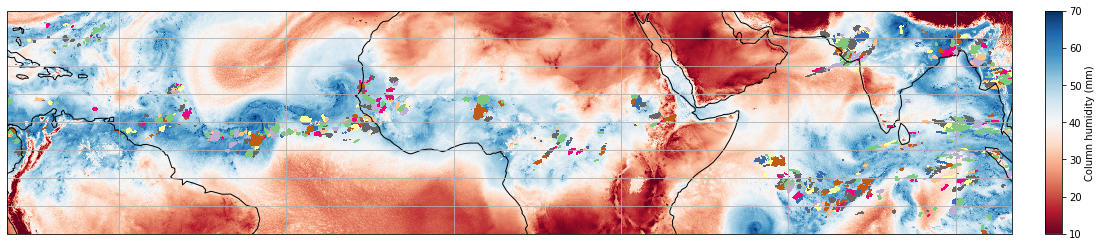

In [32]:
fig = plt.figure(figsize=(18,12))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

cmap = plt.cm.RdBu
# cmap_mcs = plt.cm.get_cmap('rainbow', 10)
cmap_mcs = plt.cm.get_cmap('Accent', 10)
clim = (10,70)
lon_lim = (280,100)
lat_lim = (-10,30)
slice_lat = slice(*lat_lim)

for slice_lon in slice(lon_lim[0],360),slice(0,lon_lim[1]):


    lat_dyamond = PW_DYAMOND.lat.sel(lat=slice_lat)
    lon_dyamond = PW_DYAMOND.lon.sel(lon=slice_lon)

    lonarray_dyamond,latarray_dyamond = np.meshgrid(lon_dyamond,lat_dyamond)
    
    # Background
    Z = PW_DYAMOND.sel(lon=slice_lon,lat=slice_lat)[0]
    # Z = Precac_DYAMOND.sel(lon=slice_lon,lat=slice_lat)[0]
    
    im = ax.pcolormesh(lonarray_dyamond,latarray_dyamond,Z,transform=ccrs.PlateCarree(),alpha=0.9,cmap=cmap)
    im.set_clim(*clim)
    
    # MCSs
    
    lat_toocan = img_TOOCAN.latitude.sel(latitude=slice_lat)
    lon_toocan = img_TOOCAN.longitude.sel(longitude=slice_lon)

    lonarray_toocan,latarray_toocan = np.meshgrid(lon_toocan,lat_toocan)

    
    IMG_SEG = img_TOOCAN.sel(longitude=slice_lon,latitude=slice_lat)[0]%10
    # IMG_roll = np.concatenate((IMG_SEG[0].values, IMG_SEG[0].values), axis=1)
    
    im_MCS = ax.pcolormesh(lonarray_toocan,latarray_toocan,IMG_SEG,transform=ccrs.PlateCarree(),cmap=cmap_mcs,alpha=1)

    
ax.set_extent([lon_lim[0]-360,lon_lim[1], *lat_lim],crs=ccrs.PlateCarree(central_longitude=0))
ax.coastlines('110m')
ax.gridlines()

# colorbar
x,y,w,h = ax.get_position().bounds
dx = w/60
cax = plt.axes([x+w+2*dx,y,dx,h])
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.set_ylabel('Column humidity (mm)')

pls.show()

# Make movie

In [133]:
import re
import gc
import matplotlib.animation as animation
import warnings

In [141]:
#-- PARAMETERS

cmap = plt.cm.RdBu
# cmap_mcs = plt.cm.get_cmap('rainbow', 10)
cmap_mcs = plt.cm.get_cmap('Accent', 10)
clim = (10,70)
lon_lim = (280,100)
lat_lim = (-10,30)

lat_dyamond = PW_DYAMOND.lat.sel(lat=slice_lat)
lon_dyamond = PW_DYAMOND.lon.sel(lon=slice_lon)

lonarray_dyamond,latarray_dyamond = np.meshgrid(lon_dyamond,lat_dyamond)


#-- INITIALIZATION

def importData(i_t):
    
    # paths
    root_DYAMOND = df.iloc[i_t]['path_dyamond'] + '.%s.2D.nc'
    file_PW_DYAMOND = root_DYAMOND%'PW'
    file_Precac_DYAMOND = root_DYAMOND%'Precac'
    path_TOOCAN = '/'+df.iloc[i_t]['img_seg_path']

    # Load DYAMOND data
    PW_DYAMOND = xr.open_dataarray(os.path.join(DIR_DYAMOND,file_PW_DYAMOND))
    
    # Load TOOCAN data
    img_TOOCAN = xr.open_dataarray(path_TOOCAN)
    
    return PW_DYAMOND, img_TOOCAN

    
def getCoords2D(dataset,slice_lon,slice_lat):
    
    # get correct coordinate names in dataset
    for prefix in 'lat','lon':
        r = re.compile("%s.*"%prefix)
        coord = list(filter(r.match,list(dataset.coords.dims)))[0]
        setattr(thismodule,'%s_coord'%prefix,coord)
    
    # extract coordinates
    lat_1D = dataset[lat_coord].sel({lat_coord:slice_lat})
    lon_1D = dataset[lon_coord].sel({lon_coord:slice_lon})

    # compute 2D meshgrid of coordinates
    lonarray,latarray = np.meshgrid(lon_1D,lat_1D)
    
    return lonarray,latarray

def showColorBar(ax,im):
    
    x,y,w,h = ax.get_position().bounds
    dx = w/60
    cax = plt.axes([x+w+2*dx,y,dx,h])
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.set_ylabel('Column humidity (mm)')

def initFigure(i_t0,title=None,norm=None):
    
    # load data
    PW_DYAMOND, img_TOOCAN = importData(i_t0)
    
    # initialize figure
    fig = plt.figure(figsize=(18,12))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

    ims = []

    for slice_lon in slice(lon_lim[0],360),slice(0,lon_lim[1]):

        #- background

        # coords
        lonarray_dyamond,latarray_dyamond = getCoords2D(PW_DYAMOND,slice_lon,slice_lat)            
        # data
        Z = PW_DYAMOND.sel(lon=slice_lon,lat=slice_lat)[0]
        # show
        im = ax.pcolormesh(lonarray_dyamond,latarray_dyamond,Z,transform=ccrs.PlateCarree(),alpha=0.9,cmap=cmap)
        im.set_clim(*clim)

        #- MCSs
        
        # coords
        lonarray_toocan,latarray_toocan = getCoords2D(img_TOOCAN,slice_lon,slice_lat)            
        # data
        IMG_SEG = img_TOOCAN.sel(longitude=slice_lon,latitude=slice_lat)[0]%10    
        # show
        im_MCS = ax.pcolormesh(lonarray_toocan,latarray_toocan,IMG_SEG,transform=ccrs.PlateCarree(),cmap=cmap_mcs,alpha=1)

        # store image placeholders for later updating
        ims.append([im,im_MCS])

    # delete data and remove from memory
    del PW_DYAMOND
    del img_TOOCAN
    del Z
    del IMG_SEG
    gc.collect()
    
    # cosmetics
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)
    showColorBar(ax,im)
        
    ax.set_extent([lon_lim[0]-360,lon_lim[1], *lat_lim],crs=ccrs.PlateCarree(central_longitude=0))
    ax.coastlines('110m')
    ax.gridlines()
    
    return fig, ax, ims

In [142]:
# Find first available index
t0_SAM = 200400
root_SAM_t0 = 'DYAMOND_9216x4608x74_7.5s_4km_4608_0000%d'%t0_SAM
j_row_t0 = df.index[df.path_dyamond == root_SAM_t0][0]
print('choose first available index:',j_row_t0)

choose first available index: 832


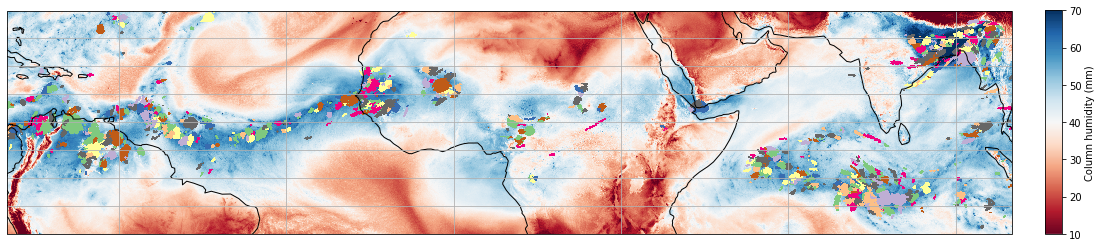

In [143]:
# first time step
i_t0 = j_row_t0

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    initFigure(i_t0)


In [177]:
#-- MOVIE

def makeMovie():
    
    Nt = len(df)
    
    # -- initialize figure
    
    # first time step
    i_t0 = j_row_t0
    
    title_root = 'Day %s'
#     t_str = str(PW_DYAMOND.time.data[0])
    
    # initialize
    fig, ax, ims = initFigure(i_t0)
    
    # -- define movie loop
    def updateImage(i_t):
        
        print(i_t,end=' ')
        
        # load data at i_t
        PW_DYAMOND, img_TOOCAN = importData(i_t)
        
        t_str = str(PW_DYAMOND.time.data[0])
        
        for slice_lon,i_ims in zip([slice(lon_lim[0],360),slice(0,lon_lim[1])],list(np.arange(2))):
        
            Z = PW_DYAMOND.sel(lon=slice_lon,lat=slice_lat)[0]
            IMG_SEG = img_TOOCAN.sel(longitude=slice_lon,latitude=slice_lat)[0]%10    

            # update images
            ims[i_ims][0].set_array(Z)
            ims[i_ims][1].set_array(IMG_SEG)
        
        ax.set_title(title_root%t_str)

        # delete data and remove from memory
        del PW_DYAMOND
        del img_TOOCAN
        del Z
        del IMG_SEG
        gc.collect()
        
        return [ims]
    
    anim = animation.FuncAnimation(fig, updateImage,
                                   frames=range(0,4), interval=1000, blit=False)

    writer = animation.writers['ffmpeg'](fps=1)

    anim.save(movie_path,writer=writer,dpi=200)#,savefig_kwargs={'bbox_inches':'tight'})

0 

FileNotFoundError: [Errno 2] No such file or directory: b'/bdd/DYAMOND/SAM-4km/OUT_2D/DYAMOND_9216x4608x74_7.5s_4km_4608_0000000720.PW.2D.nc'

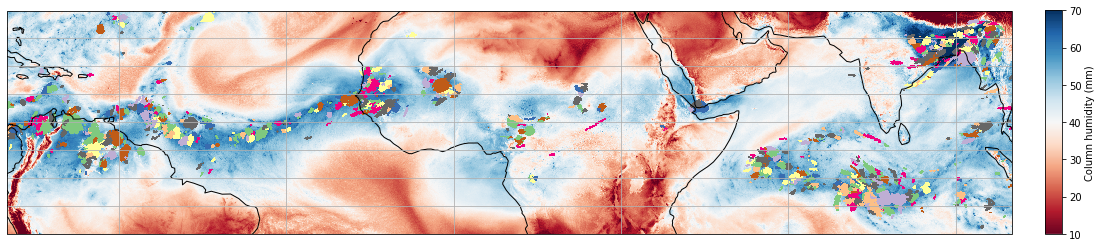

In [178]:
moviedir = '../movies/'
movie_name = 'toocan_DYAMOND_SAM'
movie_path = os.path.join(moviedir, '%s.mp4'%(movie_name))

makeMovie()